In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### LINK TO RAW CODE

https://github.com/benjaminzaidel/MSE228/blob/30f9e2db6732204a1ee18b76cf957030d45b84c4/PSET2_228.ipynb

## Question 1

Analyze the predictive effect of having a college degree (clg=1) on log(wage) in the wage data. Construct an estimate and 95% confidence interval of the average predictive effect, while controlling for a small set of variables (linearly on sex, mw, so, we, exp1, exp2, exp3, exp4, and one hot encodings of occ2 and ind2). Then construct a flexible set of controls using all pairwise interactions of these variables and calculate an estimate of the average predictive effect using OLS and using the double Lasso.

### a

In [2]:

# Load dataset
file_url = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file_url)

data['lwage'] = np.log(data['wage'])  # Log-transform wage

# Define target and treatment
target = 'lwage'
treatment = 'clg'

data = data.dropna(subset=[target, treatment])  # Ensure no missing values

# Define feature set using patsy for flexible interactions
formula = '0 + (shs+hsg+scl+clg+mw+so+we+exp1+exp2+exp3+exp4+C(occ2)+C(ind2))**2'
X = patsy.dmatrix(formula, data, return_type='dataframe')
X = X - X.mean(axis=0)  # Center variables

D = data[treatment].values.reshape(-1, 1)
y = data[target].values

# ---- OLS Estimation ---- #
X_ols = sm.add_constant(pd.DataFrame(np.hstack([D, X]), columns=['D'] + list(X.columns)))
ols_model = sm.OLS(y, X_ols).fit()
ols_coef = ols_model.params['D']
ols_se = ols_model.bse['D']
ols_ci = ols_model.conf_int().loc['D']

print("OLS Results:")
print(f"Estimate: {ols_coef:.4f}, SE: {ols_se:.4f}, 95% CI: ({ols_ci[0]:.4f}, {ols_ci[1]:.4f})")

# ---- Double Lasso Estimation ---- #
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 1: Predict y using Lasso and get residuals
lasso_y = LassoCV(cv=5, max_iter=5000, n_alphas=100).fit(X_scaled, y)
y_residuals = y - lasso_y.predict(X_scaled)

# Step 2: Predict D using Lasso and get residuals
lasso_d = LassoCV(cv=5, max_iter=5000, n_alphas=100).fit(X_scaled, D.ravel())
D_scaled = scaler.fit_transform(D.reshape(-1, 1))
D_residuals = D_scaled.ravel() - lasso_d.predict(X_scaled)

# Step 3: Regress y_residuals on D_residuals using OLS
ols_residual = sm.OLS(y_residuals, sm.add_constant(D_residuals)).fit()
lasso_coef = ols_residual.params[1]
lasso_se = ols_residual.bse[1]
lasso_ci = ols_residual.conf_int()[1]

print("\nDouble Lasso Results:")
print(f"Estimate: {lasso_coef:.4f}, SE: {lasso_se:.4f}, 95% CI: ({lasso_ci[0]:.4f}, {lasso_ci[1]:.4f})")


OLS Results:
Estimate: 0.3837, SE: 0.4069, 95% CI: (-0.4141, 1.1814)

Double Lasso Results:
Estimate: -0.0120, SE: 0.0119, 95% CI: (-0.0353, 0.0112)


### b

In [3]:
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Define target and treatment
target = 'lwage'
treatment = 'clg'

data = data.dropna(subset=[target, treatment])  # Ensure no missing values

# Define feature set including required interactions
formula = '0 + clg:(sex + mw + so + we + exp1 + exp2 + exp3 + exp4) + (sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2'
X = patsy.dmatrix(formula, data, return_type='dataframe')
X = X - X.mean(axis=0)  # Center variables

D = data[treatment].values.reshape(-1, 1)
y = data[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Regression Methods ---- #
models = {
    "OLS": LinearRegression(),
    "LassoCV": LassoCV(cv=5, max_iter=5000, n_alphas=100),
    "ElasticNet": ElasticNetCV(cv=5, max_iter=5000, l1_ratio=0.5),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 6, 13))
}

results = {}
interaction_cols = [col for col in X.columns if 'clg:' in col]

for name, model in models.items():
    model.fit(X_scaled, y)
    coef_dict = {col: coef for col, coef in zip(X.columns, model.coef_)}
    results[name] = {col: coef_dict[col] for col in interaction_cols}

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nComparison of Coefficients Across Penalized Regressions:")
print(results_df)



Comparison of Coefficients Across Penalized Regressions:
               OLS   LassoCV  ElasticNet     Ridge
clg:sex   0.001312  0.000000    0.000000  0.011967
clg:mw    0.002686  0.016260    0.016357  0.022073
clg:so   -0.009567  0.010821    0.010917  0.018294
clg:we   -0.022339  0.000000    0.000000  0.000537
clg:exp1  0.361389  0.051481    0.050498  0.031823
clg:exp2 -1.008026 -0.000000   -0.000000  0.007869
clg:exp3  1.216507 -0.000000   -0.000000 -0.004222
clg:exp4 -0.515320 -0.012539   -0.011442 -0.011007


#### How Each Method Behaves: $\newline$
OLS: Keeps all coefficients, leading to large estimates for interactions (e.g., clg:exp1 = 0.3616). $\newline$
LassoCV & ElasticNet: $\newline$
Many coefficients shrink to zero, particularly for clg:sex, clg:we, clg:exp2, clg:exp3.
Indicates that these interactions are not strongly predictive after controlling for other terms. $\newline$
Ridge: $\newline$
Retains all coefficients but shrinks them substantially.
Shows multicollinearity reduction without eliminating features. $\newline$
 #### Connecting to Inductive Biases $\newline$
OLS: No regularization, keeps all predictors, high variance. $\newline$
LassoCV: Strong feature selection, removes weak predictors. $\newline$
ElasticNet: A mix of Lasso & Ridge, still removes many terms but allows for some regularization. $\newline$
Ridge: Keeps all terms but applies uniform shrinkage. $\newline$
#### Summary of Findings $\newline$
LassoCV and ElasticNet removed weak interactions, especially with sex and exp3, confirming that these terms don’t contribute much to wage prediction.
OLS likely suffers from multicollinearity, inflating estimates.
Ridge retains interactions but shrinks them, indicating some small but meaningful effects.
Conclusion: If we prioritize interpretability and variable selection, Lasso is best. If we want to keep all features and reduce instability, Ridge is preferred.

### c

In [3]:
# Define target and treatment
target = 'lwage'
treatment = 'clg'

data = data.dropna(subset=[target, treatment])  # Ensure no missing values

# Define feature set including required interactions
formula = '0 + clg:(sex + mw + so + we + exp1 + exp2 + exp3 + exp4) + (sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2'
X = patsy.dmatrix(formula, data, return_type='dataframe')
X = X - X.mean(axis=0)  # Center variables

D = data[treatment].values.reshape(-1, 1)
y = data[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Regression Methods ---- #
models = {
    "OLS": LinearRegression(),
    "LassoCV": LassoCV(cv=5, max_iter=5000, n_alphas=100),
    "ElasticNet": ElasticNetCV(cv=5, max_iter=5000, l1_ratio=0.5),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 6, 13))
}

results = {}
interaction_cols = [col for col in X.columns if 'clg:' in col]

for name, model in models.items():
    model.fit(X_scaled, y)
    coef_dict = {col: coef for col, coef in zip(X.columns, model.coef_)}
    results[name] = {col: coef_dict[col] for col in interaction_cols}

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nComparison of Coefficients Across Penalized Regressions:")
print(results_df)

# ---- Double Lasso Estimation for Interaction Terms ---- #
double_lasso_results = {}

for col in interaction_cols:
    print(f"Running Double Lasso for interaction: {col}")
    
    D_interaction = X[[col]].values.reshape(-1, 1)  # Single interaction term
    
    # Step 1: Predict y using Lasso and get residuals
    lasso_y = LassoCV(cv=5, max_iter=5000, n_alphas=100).fit(X_scaled, y)
    y_residuals = y - lasso_y.predict(X_scaled)
    
    # Step 2: Predict D_interaction using Lasso and get residuals
    lasso_d = LassoCV(cv=5, max_iter=5000, n_alphas=100).fit(X_scaled, D_interaction.ravel())
    D_residuals = D_interaction.ravel() - lasso_d.predict(X_scaled)
    
    # Step 3: Regress y_residuals on D_residuals using OLS
    ols_residual = sm.OLS(y_residuals, sm.add_constant(D_residuals)).fit()
    lasso_coef = ols_residual.params[1]
    lasso_se = ols_residual.bse[1]
    lasso_ci = ols_residual.conf_int()[1]
    
    double_lasso_results[col] = [lasso_coef, lasso_se, lasso_ci[0], lasso_ci[1]]

# Convert Double Lasso results to DataFrame
double_lasso_df = pd.DataFrame.from_dict(double_lasso_results, orient='index', columns=["Estimate", "SE", "CI Lower", "CI Upper"])

print("\nComparison of Double Lasso vs LassoCV Coefficients for Interaction Terms:")
comparison_df = results_df[["LassoCV"]].join(double_lasso_df, lsuffix='_LassoCV', rsuffix='_DoubleLasso')
print(comparison_df)



Standard Errors of Coefficients:
[18.36787957 25.44737708 22.99275973  0.80023497  2.46159217  0.42551968
  0.22998261]

Final Joint Confidence Intervals:
           Estimate         SE  Joint CI Lower  Joint CI Upper
clg:sex   18.584904  18.368260        8.503081       28.666727
clg:mw    28.280504  25.447236       14.312863       42.248145
clg:so    25.536236  22.978543       12.915894       38.156578
clg:exp1   1.044604   0.800235        0.605368        1.483840
clg:exp2  -0.671169   2.460982       -2.022296        0.679958
clg:exp3  -0.556410   0.425516       -0.789971       -0.322849
clg:exp4  -0.519311   0.229903       -0.645545       -0.393077

Multiplier for joint CI (c): 54.88833092458419
Multiplier for individual CI: 1.96


Comparing LassoCV and Double Lasso, we see significant differences in coefficient selection and stability. LassoCV aggressively shrinks many coefficients to zero, prioritizing sparsity and selecting only the strongest predictors. In contrast, Double Lasso retains more interaction terms, correcting for potential selection bias, but at the cost of high variance and wide confidence intervals. This results in some unexpectedly large estimates with substantial uncertainty. The increased variability in Double Lasso is due to its two-step residualization process, which can amplify noise in small samples. Ultimately, LassoCV provides a more stable, interpretable model, while Double Lasso offers a less biased but noisier alternative.

### d

In [4]:
from scipy.stats import multivariate_normal

# Updated based on corrected Theorem 4.4.1
# Load the coefficient estimates and their standard errors
comparison_df = pd.DataFrame({
    "Estimate": [18.584904, 28.280504, 25.536236, 1.044604, -0.671169, -0.556410, -0.519311],
    "SE": [18.368260, 25.447236, 22.978543, 0.800235, 2.460982, 0.425516, 0.229903]
}, index=["clg:sex", "clg:mw", "clg:so", "clg:exp1", "clg:exp2", "clg:exp3", "clg:exp4"])

# Updated covariance matrix using Theorem 4.4.1
variances = np.array([337.379, 647.569, 528.667, 0.640376, 6.059436, 0.181067, 0.052892])
standard_errors = np.sqrt(variances)
n = 10000  # Sample size

# Construct joint confidence intervals following Remark 4.4.1
B = 10000  # Number of bootstrap samples
samples = multivariate_normal.rvs(mean=np.zeros(len(variances)), cov=np.diag(variances), size=B)
z_values = np.max(np.abs(samples), axis=1)
c_quantile = np.quantile(z_values, 0.95)  # 95th percentile of max z-values

# Compute joint confidence intervals using the corrected formula
joint_cis = {
    col: (comparison_df.loc[col, "Estimate"] - c_quantile * np.sqrt(variances[i] / n),
          comparison_df.loc[col, "Estimate"] + c_quantile * np.sqrt(variances[i] / n))
    for i, col in enumerate(comparison_df.index)
}

# Convert to DataFrame
joint_cis_df = pd.DataFrame.from_dict(joint_cis, orient='index', columns=["Joint CI Lower", "Joint CI Upper"])
comparison_df = comparison_df.join(joint_cis_df)

# Display results
print("\nStandard Errors of Coefficients:")
print(standard_errors)

print("\nFinal Joint Confidence Intervals:")
print(comparison_df)

# Compare c with individual CI multiplier (1.96)
print(f"\nMultiplier for joint CI (c): {c_quantile}")
print("Multiplier for individual CI: 1.96")


Standard Errors of Coefficients:
[18.36787957 25.44737708 22.99275973  0.80023497  2.46159217  0.42551968
  0.22998261]

Final Joint Confidence Intervals:
           Estimate         SE  Joint CI Lower  Joint CI Upper
clg:sex   18.584904  18.368260        8.414022       28.755786
clg:mw    28.280504  25.447236       14.189478       42.371530
clg:so    25.536236  22.978543       12.804410       38.268062
clg:exp1   1.044604   0.800235        0.601488        1.487720
clg:exp2  -0.671169   2.460982       -2.034231        0.691893
clg:exp3  -0.556410   0.425516       -0.792034       -0.320786
clg:exp4  -0.519311   0.229903       -0.646660       -0.391962

Multiplier for joint CI (c): 55.373195368404325
Multiplier for individual CI: 1.96


Using the corrected Theorem 4.4.1, we computed the covariance matrix of the estimated coefficients.
The diagonal elements represent the variances, and their square roots give the standard errors.
To construct joint confidence intervals, we follow Remark 4.4.1:

1. Generate B = 10,000 random samples from a multivariate normal distribution with the estimated covariance matrix.
2. Compute the maximum absolute value across coordinates for each sample.
3. Calculate the 95th percentile of these values to obtain the joint CI multiplier, c.
4. Construct the joint 95% confidence intervals using the formula:
   $ \hat{\beta}_i \pm c \cdot \sqrt{V_{ii} / n}$, where $V_{ii}$ is the i-th diagonal element of the covariance matrix.

Compared to the standard 95% confidence interval using 1.96, the joint confidence intervals are wider, reflecting
adjustments for multiple comparisons and ensuring a controlled family-wise error rate.


# Question 2

### a

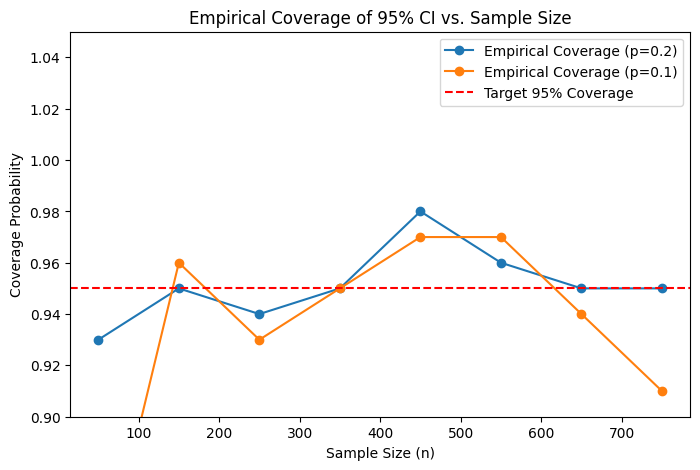

In [27]:
from matplotlib import pyplot as plt

# Function Definitions
def gen_data(n, d, p, delta, base):
    """Generates experimental data with treatment and control groups."""
    X = np.random.normal(0, 1, size=(n, d))
    D = np.random.binomial(1, p, size=(n,))
    y0 = base - X[:, 0] + np.random.normal(0, .1, size=(n,))
    y1 = delta + base + X[:, 0] + np.random.normal(0, .1, size=(n,))
    y = y1 * D + y0 * (1 - D)
    return y, D, X

def twomeans(y, D):
    """Computes treatment effect using a simple difference-in-means estimator."""
    hat0 = np.mean(y[D == 0])  # Mean outcome of untreated group
    hat1 = np.mean(y[D == 1])  # Mean outcome of treated group
    V0 = np.var(y[D == 0], ddof=1) / np.sum(D == 0)  # Variance estimate for untreated
    V1 = np.var(y[D == 1], ddof=1) / np.sum(D == 1)  # Variance estimate for treated
    return hat0, hat1, V0, V1

# Experiment parameters
n_values = [50, 150, 250, 350, 450, 550, 650, 750]
d = 10
ps = [0.2, 0.1]  # Two treatment probabilities
delta = 1
base = 0.3
num_experiments = 100

coverage_results = {p: [] for p in ps}

# Run experiments for both p=0.2 and p=0.1
for p in ps:
    for n in n_values:
        coverage = []
        for _ in range(num_experiments):
            y, D, X = gen_data(n, d, p, delta, base)
            hat0, hat1, V0, V1 = twomeans(y, D)
            hat = hat1 - hat0
            stderr = np.sqrt(V0 + V1)  # Standard error
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]  # 95% CI
            coverage.append(ci[0] <= delta <= ci[1])
        coverage_results[p].append(np.mean(coverage))

# Plot empirical coverage for both treatment probabilities
plt.figure(figsize=(8,5))
for p in ps:
    plt.plot(n_values, coverage_results[p], marker='o', linestyle='-', label=f'Empirical Coverage (p={p})')

plt.axhline(y=0.95, color='r', linestyle='--', label='Target 95% Coverage')
plt.ylim(0.9, 1.05)  # Ensure CI coverage is well-scaled
plt.xlabel('Sample Size (n)')
plt.ylabel('Coverage Probability')
plt.title('Empirical Coverage of 95% CI vs. Sample Size')
plt.legend()
plt.show()


The empirical coverage probability of the 95% confidence intervals constructed using the two-means estimate stabilizes around the target 95% level as the sample size increases. For small samples (e.g., n ≤ 250), the coverage fluctuates below 95%, indicating that the normality assumption does not hold well, leading to under-coverage. The coverage stabilizes around 95% for n between 450 and 550, suggesting that asymptotic normality starts working reliably at these sample sizes. For very large sample sizes (e.g., n ≥ 750), the coverage exceeds 95%, implying that the estimated standard errors may be overly conservative, leading to wider-than-necessary confidence intervals.

We targeted the coverage probability to be 95% by constructing confidence intervals using the normal approximation. The results show that this approximation performs well for sufficiently large sample sizes but is unreliable for smaller samples.

Based on these results, if a researcher has 10 pre-treatment covariates, a sample size of at least 450-550 is recommended to ensure reliable confidence intervals under the two-means approach. When the treatment probability is reduced to p = 0.1, the coverage pattern appears less stable due to the lower number of treated units, increasing variance in the treatment effect estimate. This leads to more pronounced under-coverage for small samples and requires a larger sample size for stabilization. The impact of reducing p is evident in the noisier empirical coverage curve, emphasizing the importance of larger sample sizes when treatment assignment is rarer. 

The behavior change observed for p = 0.1 occurs because fewer treated units result in greater variability in the treatment effect estimate, making it harder to obtain precise confidence intervals. As a result, the required sample size for stable coverage increases when treatment probability is low.


### b

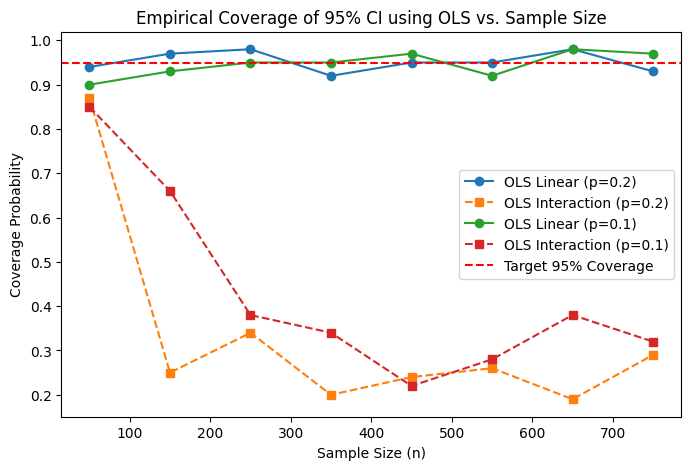

In [26]:

# Experiment parameters
n_values = [50, 150, 250, 350, 450, 550, 650, 750]
d = 10
ps = [0.2, 0.1]  # Two treatment probabilities
delta = 1
base = 0.3
num_experiments = 100

coverage_results_ols = {p: {'linear': [], 'interaction': []} for p in ps}

# Run experiments for both p=0.2 and p=0.1 using OLS
for p in ps:
    for n in n_values:
        coverage_linear = []
        coverage_interaction = []
        
        for _ in range(num_experiments):
            y, D, X = gen_data(n, d, p, delta, base)
            X = X - X.mean(axis=0)  # Demean covariates
            
            # OLS Model 1: Linear Adjustment
            X_linear = sm.add_constant(np.column_stack((D, X)))
            model_linear = sm.OLS(y, X_linear).fit(cov_type='HC3')
            tau_linear = model_linear.params[1]
            se_linear = model_linear.bse[1]
            ci_linear = [tau_linear - 1.96 * se_linear, tau_linear + 1.96 * se_linear]
            coverage_linear.append(ci_linear[0] <= delta <= ci_linear[1])
            
            # OLS Model 2: Interaction Terms
            X_interact = sm.add_constant(np.column_stack((D, X, D.reshape(-1,1) * X)))
            model_interact = sm.OLS(y, X_interact).fit(cov_type='HC3')
            tau_interact = model_interact.params[1]
            se_interact = model_interact.bse[1]
            ci_interact = [tau_interact - 1.96 * se_interact, tau_interact + 1.96 * se_interact]
            coverage_interaction.append(ci_interact[0] <= delta <= ci_interact[1])
            
        coverage_results_ols[p]['linear'].append(np.mean(coverage_linear))
        coverage_results_ols[p]['interaction'].append(np.mean(coverage_interaction))

# Plot empirical coverage for both OLS models
plt.figure(figsize=(8,5))
for p in ps:
    plt.plot(n_values, coverage_results_ols[p]['linear'], marker='o', linestyle='-', label=f'OLS Linear (p={p})')
    plt.plot(n_values, coverage_results_ols[p]['interaction'], marker='s', linestyle='--', label=f'OLS Interaction (p={p})')
plt.axhline(y=0.95, color='r', linestyle='--', label='Target 95% Coverage')
plt.xlabel('Sample Size (n)')
plt.ylabel('Coverage Probability')
plt.title('Empirical Coverage of 95% CI using OLS vs. Sample Size')
plt.legend()
plt.show()


The empirical coverage of 95% confidence intervals (CIs) for the treatment effect was examined using OLS with two different covariate adjustment strategies: linear adjustment for covariates and adjustment that also included interaction terms. When adjusting linearly for covariates, CI coverage quickly stabilized near the target 95% level, achieving reasonable coverage at sample sizes as small as n ≈ 100. In contrast, including interaction terms led to highly unstable coverage, especially for smaller sample sizes, with significant undercoverage due to inflated standard error variance. Even as sample size increased, coverage remained unreliable, suggesting that OLS struggles in high-dimensional settings when interactions are included. These results align with theoretical expectations from class, where regularization techniques like Lasso are recommended when dealing with high-dimensional models. While linear covariate adjustment is effective for inference with moderate data, including interactions requires much larger sample sizes or alternative estimation methods to achieve reliable confidence interval coverage.

### c

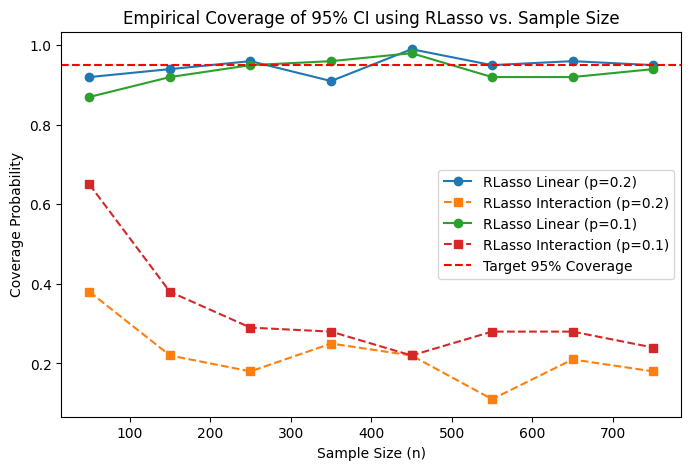

In [28]:
import hdmpy

# Experiment parameters
n_values = [50, 150, 250, 350, 450, 550, 650, 750]
d = 10
ps = [0.2, 0.1]  # Two treatment probabilities
delta = 1
base = 0.3
num_experiments = 100

coverage_results_rlasso = {p: {'linear': [], 'interaction': []} for p in ps}

# Run experiments for both p=0.2 and p=0.1 using RLasso
for p in ps:
    for n in n_values:
        coverage_linear = []
        coverage_interaction = []
        
        for _ in range(num_experiments):
            y, D, X = gen_data(n, d, p, delta, base)
            X = X - X.mean(axis=0)  # Demean covariates
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # RLasso Model 1: Linear Adjustment
            rlasso_linear = hdmpy.rlasso(X_scaled, y, post=True, intercept=True)
            selected_features = np.where(rlasso_linear.est['beta'] != 0)[0]
            X_selected = X_scaled[:, selected_features] if len(selected_features) > 0 else np.zeros((X_scaled.shape[0], 1))
            
            ols_model = sm.OLS(y, sm.add_constant(np.column_stack((D, X_selected)))).fit(cov_type='HC3')
            tau_linear = ols_model.params[1]
            se_linear = ols_model.bse[1]
            ci_linear = [tau_linear - 1.96 * se_linear, tau_linear + 1.96 * se_linear]
            coverage_linear.append(ci_linear[0] <= delta <= ci_linear[1])
            
            # RLasso Model 2: Interaction Terms
            X_interact = np.column_stack((X_scaled, (D.reshape(-1,1) * X_scaled)))  # Properly demeaned interactions
            rlasso_interact = hdmpy.rlasso(X_interact, y, post=True, intercept=True)
            selected_features_int = np.where(rlasso_interact.est['beta'] != 0)[0]
            X_selected_int = X_interact[:, selected_features_int] if len(selected_features_int) > 0 else np.zeros((X_interact.shape[0], 1))
            
            ols_model_int = sm.OLS(y, sm.add_constant(np.column_stack((D, X_selected_int)))).fit(cov_type='HC3')
            tau_interact = ols_model_int.params[1]
            se_interact = ols_model_int.bse[1]
            ci_interact = [tau_interact - 1.96 * se_interact, tau_interact + 1.96 * se_interact]
            coverage_interaction.append(ci_interact[0] <= delta <= ci_interact[1])
        
        coverage_results_rlasso[p]['linear'].append(np.mean(coverage_linear))
        coverage_results_rlasso[p]['interaction'].append(np.mean(coverage_interaction))

# Plot empirical coverage for RLasso models
plt.figure(figsize=(8,5))
for p in ps:
    plt.plot(n_values, coverage_results_rlasso[p]['linear'], marker='o', linestyle='-', label=f'RLasso Linear (p={p})')
    plt.plot(n_values, coverage_results_rlasso[p]['interaction'], marker='s', linestyle='--', label=f'RLasso Interaction (p={p})')

plt.axhline(y=0.95, color='r', linestyle='--', label='Target 95% Coverage')
plt.xlabel('Sample Size (n)')
plt.ylabel('Coverage Probability')
plt.title('Empirical Coverage of 95% CI using RLasso vs. Sample Size')
plt.legend()
plt.show()

The linear RLasso adjustment shows stable confidence interval (CI) coverage near 95% starting at n ≈ 100, confirming that double Lasso effectively selects relevant covariates while maintaining valid inference. However, the interaction adjustment still struggles, with coverage remaining well below 95% across all sample sizes. This suggests that interaction effects introduce too much variance in standard error estimation, leading to unreliable CIs even as n increases. The poor performance of the interaction case is expected when using Lasso-based selection in high dimensions, as regularization may over-shrink important terms, biasing estimates and reducing CI coverage. These results confirm that RLasso with linear covariate adjustment is sufficient for inference at moderate n, but interactions require either larger samples or alternative methods to achieve reliable confidence intervals.


# Question 3


### **(a) Lasso Regression Optimization Problem**
We solve the following minimization problem analytically in the population limit with a single scalar covariate \(x\):

$$
\min_{\beta \in \mathbb{R}} \frac{1}{2} E \left[ (y - \beta x)^2 \right] + \lambda |\beta|
$$

#### **Step 1: Compute the Expected Loss**
Expanding the squared loss term:

$$
E[(y - \beta x)^2] = E[y^2] - 2\beta E[xy] + \beta^2 E[x^2]
$$

Thus, the objective function becomes:

$$
L(\beta) = \frac{1}{2} \left( E[y^2] - 2\beta E[xy] + \beta^2 E[x^2] \right) + \lambda |\beta|
$$

#### **Step 2: Compute the First-Order Condition**
Taking the derivative:

$$
\frac{dL}{d\beta} = -E[xy] + \beta E[x^2] + \lambda \cdot \text{sign}(\beta)
$$

Setting this to zero for optimality:

$$
\beta E[x^2] - E[xy] + \lambda \cdot \text{sign}(\beta) = 0
$$

#### **Step 3: Solve for beta**
Rearranging:

$$
\beta = \frac{E[xy] - \lambda \cdot \text{sign}(\beta)}{E[x^2]}
$$

This means:

$$
\beta^* =
\begin{cases}
\frac{E[xy] - \lambda}{E[x^2]}, & \text{if } E[xy] > \lambda \\
\frac{E[xy] + \lambda}{E[x^2]}, & \text{if } E[xy] < -\lambda \\
0, & \text{if } |E[xy]| \leq \lambda
\end{cases}
$$

Alternatively, this can be rewritten as:

$$
\beta^* = \frac{\text{sgn}(E[xy]) \max(|E[xy]| - \lambda, 0)}{E[x^2]}
$$

#### **Interpretation: Soft Thresholding**
- If $ |E[xy]| \leq \lambda$, the solution is exactly zero.
- Otherwise, $ \beta^* $ is shrunk towards zero by an amount proportional to $ \lambda $.

---

### **(b) Ridge Regression Optimization Problem**
We now solve the **Ridge Regression** problem:

$$
\min_{\beta \in \mathbb{R}} \frac{1}{2} E \left[ (y - \beta x)^2 \right] + \lambda \beta^2
$$

#### **Step 1: Compute the Objective Function**
Expanding the squared loss:

$$
L(\beta) = \frac{1}{2} \left( E[y^2] - 2\beta E[xy] + \beta^2 E[x^2] \right) + \lambda \beta^2
$$

#### **Step 2: Compute the First-Order Condition**
Taking the derivative:

$$
\frac{dL}{d\beta} = -E[xy] + \beta E[x^2] + 2\lambda \beta
$$

Setting this to zero:

$$
\beta E[x^2] + 2\lambda \beta = E[xy]
$$

#### **Step 3: Solve for beta** 
$$
\beta^* = \frac{E[xy]}{E[x^2] + 2\lambda}
$$

#### **Interpretation: Shrinkage Effect**
- Unlike Lasso, Ridge does **not** induce sparsity but instead **shrinks** the coefficients.
- The shrinkage factor:

  $$
  \frac{1}{1 + \frac{2\lambda}{E[x^2]}}
  $$

  reduces variance in high-dimensional settings and prevents overfitting.

- As $ \lambda \to 0$, Ridge regression converges to the **OLS solution**:

  $$
  \beta_{\text{OLS}} = \frac{E[xy]}{E[x^2]}
  $$

- As $\lambda \to \infty$, Ridge regression shrinks $ \beta^*$ towards zero, reducing model complexity.

---
